In [1]:
import os
import sys
from datetime import datetime

In [2]:
# -------------------------------------------------------------
# Environment setup
# -------------------------------------------------------------
BASE_DIR = os.path.abspath("../")
sys.path.append(BASE_DIR)

# -------------------------------------------------------------
# Configuration
# -------------------------------------------------------------
from src.utils.config import load_config
config = load_config(base_dir=BASE_DIR)

# Selección automática del número de clusters K usando Score Combinado

## Delta Inertia - Elbow clasico

En K-Means, la **inercia** representa la suma de las distancias cuadradas de cada punto a su centroide:

$$
\text{Inertia} = \sum_{i=1}^{N} \|x_i - \mu_{c_i}\|^2
$$

- A medida que **K aumenta**, la inercia siempre disminuye, ya que los centros de los clusters están más cercanos a los puntos.  
- Para detectar el **codo (elbow)**, definimos:

$$
\Delta \text{Inertia}[k] = \text{Inertia}[k-1] - \text{Inertia}[k]
$$

- Este valor indica cuánto disminuye la inercia al aumentar K en 1. El “mejor” K suele estar donde la reducción significativa se detiene.

---

## Score Combinado

Para automatizar la elección del número de clusters, combinamos tres métricas internas:

1. **Silhouette Score**: mide cohesión y separación de los clusters.  
2. **Calinski–Harabasz (CH) Score**: mide densidad interna y separación de clusters.  
3. **Delta Inertia**: captura el codo en la inercia.

La fórmula del **score combinado** es:

$$
\text{Score Combinado}[k] =
\frac{\text{Silhouette Mean}[k]}{\text{Silhouette Var}[k] + \epsilon} +
\frac{\text{CH Mean}[k]}{\text{CH Var}[k] + \epsilon} +
\frac{\Delta \text{Inertia}[k]}{\text{Inertia Var}[k] + \epsilon}
$$

- \(\epsilon\) es un valor muy pequeño para evitar división por cero.  
- Cada término busca que la métrica sea **alta y estable** entre distintas corridas (runs) de K-Means.

| Componente           | Qué mide                        | Qué buscamos                  |
|---------------------|---------------------------------|-------------------------------|
| Silhouette Mean / Var | Cohesión y separación           | Alto y estable                |
| CH Mean / Var        | Separación y densidad de clusters | Alto y estable                |
| Delta Inertia / Var  | Cambio de inercia al aumentar K | Alto y estable (codo definido)|

---

## A Favor

- Integra **tres métricas diferentes** en un solo valor.  
- Permite seleccionar **automáticamente el mejor K** sin depender de la interpretación visual del codo.  
- Más robusto cuando se hacen **múltiples corridas** con distintas inicializaciones o muestras.

---

- El **K con el score combinado más alto** es el óptimo según estas métricas.  
- La metodología considera tanto **calidad de los clusters** como **estabilidad entre runs**.
- Como autor me inteereza tener una variedad de grupos, por eso penalizo los valores minimos


In [ ]:
import time
import pickle

import dask.dataframe as dd

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from dask_ml.preprocessing import StandardScaler
from dask_ml.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score

import matplotlib.pyplot as plt


In [4]:
tensors_normalized_L2 = config["paths"]["tensors_normalized_L2"]
tensors_normalized_L1 = config["paths"]["tensors_normalized_L1"]
tensors_svd = config["paths"]["tensors_svd"]
data = dd.read_parquet(tensors_svd)

# Separar ID y features
ids = data.iloc[:, 0]
features_df = data.iloc[:, 1:].astype('float64')

# CLAVE: Convertir DataFrame a Dask Array
features = features_df.to_dask_array(lengths=True)
print(f"Forma del array: {features.shape}")
print(f"Tipo: {type(features)}")

data.head()

Forma del array: (29037493, 20)
Tipo: <class 'dask.array.core.Array'>


,row_id,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,...,svd_10,svd_11,svd_12,svd_13,svd_14,svd_15,svd_16,svd_17,svd_18,svd_19
0,+++AhJk2QJM=_0,0.006205,0.517851,-0.115916,-0.967972,-0.320077,-0.068502,0.255377,0.040823,0.097394,...,0.052599,-0.075849,-0.084619,0.444650,-0.057621,-0.045088,-0.035509,-0.011000,-0.078737,-0.062345
1,+++AhJk2QJM=_1,-0.563860,-0.230911,0.315015,-0.063151,-0.285392,-0.041747,0.186106,0.003272,0.099422,...,0.006170,-0.166224,-0.078923,-0.109955,-0.107116,0.016595,-0.087999,-0.000677,0.070822,0.077504
2,+++AhJk2QJM=_2,-0.688080,-0.136094,0.140357,-0.029975,-0.268884,-0.042117,0.119032,0.020225,0.075459,...,0.007374,-0.132202,-0.062002,-0.134192,-0.102226,0.022491,-0.046442,-0.006650,0.109054,0.111554
3,+++AhJk2QJM=_3,-0.638014,0.010540,-0.219359,-0.117566,-0.280457,-0.035270,0.005392,0.027922,0.043870,...,0.017750,-0.071149,-0.023939,0.098798,-0.047077,0.007832,0.002586,-0.035711,-0.022149,0.000176
4,+++AhJk2QJM=_4,-0.674762,-0.073510,-0.076936,-0.022603,-0.295467,-0.024799,-0.096720,0.016899,0.042034,...,0.010573,-0.080996,-0.024678,0.049263,-0.055441,0.032812,-0.027378,-0.022760,-0.045537,-0.035994


In [20]:
SAMPLE_FRACTION = 0.0001
random_seed = 42
N_RUNS = 30
k_range = list(range(2, 65, 2))

montecarlo_metrics = {
    "config": {
        "sample_fraction": SAMPLE_FRACTION,
        "random_seed": random_seed,
        "n_runs": N_RUNS,
        "k_range": k_range
    },
    "runs": []
}

for run in range(N_RUNS):
    print(f"\n====== RUN {run+1}/{N_RUNS} ======")

    # Sample
    sample_df_dask = data.sample(
        frac=SAMPLE_FRACTION,
        random_state=random_seed + run
    )
    df = sample_df_dask.iloc[:, 1:].compute().astype("float64")

    print(f"Sample shape: {df.shape}")

    inertia_vals = []
    ch_vals = []
    sil_vals = []

    # K loop
    for k in k_range:
        # print(f"  k={k}")

        kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
        labels = kmeans.fit_predict(df)

        inertia_vals.append(kmeans.inertia_)
        ch_vals.append(calinski_harabasz_score(df, labels))
        sil_vals.append(silhouette_score(df, labels))

    montecarlo_metrics["runs"].append({
        "run_id": run,
        "sample_shape": df.shape,
        "inertia": inertia_vals,
        "calinski_harabasz": ch_vals,
        "silhouette": sil_vals
    })

# Save to pickle
with open("montecarlo_metrics.pkl", "wb") as f:
    pickle.dump(montecarlo_metrics, f)

print("\nProcesamiento terminado.")


====== RUN 1/30 ======
Sample shape: (2856, 20)

====== RUN 2/30 ======
Sample shape: (2856, 20)

====== RUN 3/30 ======
Sample shape: (2856, 20)

====== RUN 4/30 ======
Sample shape: (2856, 20)

====== RUN 5/30 ======
Sample shape: (2856, 20)

====== RUN 6/30 ======
Sample shape: (2856, 20)

====== RUN 7/30 ======
Sample shape: (2856, 20)

====== RUN 8/30 ======
Sample shape: (2856, 20)

====== RUN 9/30 ======
Sample shape: (2856, 20)

====== RUN 10/30 ======
Sample shape: (2856, 20)

====== RUN 11/30 ======
Sample shape: (2856, 20)

====== RUN 12/30 ======
Sample shape: (2856, 20)

====== RUN 13/30 ======
Sample shape: (2856, 20)

====== RUN 14/30 ======
Sample shape: (2856, 20)

====== RUN 15/30 ======
Sample shape: (2856, 20)

====== RUN 16/30 ======
Sample shape: (2856, 20)

====== RUN 17/30 ======
Sample shape: (2856, 20)

====== RUN 18/30 ======
Sample shape: (2856, 20)

====== RUN 19/30 ======
Sample shape: (2856, 20)

====== RUN 20/30 ======
Sample shape: (2856, 20)

====== R

In [22]:
import pickle

with open("clustering_results.pkl", "wb") as f:
    pickle.dump(montecarlo_metrics, f)

montecarlo_metrics["runs"][0]["sample_shape"]
montecarlo_metrics["runs"][0].keys()

dict_keys(['run_id', 'sample_shape', 'inertia', 'calinski_harabasz', 'silhouette'])

In [ ]:

# Cargar metricas desde el diccionario
runs = montecarlo_metrics["runs"]
k_values = np.array(montecarlo_metrics["config"]["k_range"])

# Convertir listas de runs → matrices numpy
inertia_arr = np.array([r["inertia"] for r in runs])
ch_arr      = np.array([r["calinski_harabasz"] for r in runs])
sil_arr     = np.array([r["silhouette"] for r in runs])

# Estadisticas
inertia_median = np.median(inertia_arr, axis=0)
ch_median      = np.median(ch_arr, axis=0)
sil_median     = np.median(sil_arr, axis=0)

inertia_std = np.std(inertia_arr, axis=0)
ch_std      = np.std(ch_arr, axis=0)
sil_std     = np.std(sil_arr, axis=0)

# Elbow automatico
scaler = MinMaxScaler()
inertia_scaled = scaler.fit_transform(inertia_median.reshape(-1, 1)).flatten()
second_diff = np.diff(np.diff(inertia_scaled))
elbow_k = k_values[np.argmax(np.abs(second_diff)) + 2]
elbow_score = 1 - (np.abs(k_values - elbow_k) / np.abs(k_values - elbow_k).max())

# Normalizacion
inertia_norm = 1 - inertia_scaled
ch_norm  = scaler.fit_transform(ch_median.reshape(-1, 1)).flatten()
sil_norm = scaler.fit_transform(sil_median.reshape(-1, 1)).flatten()

# Penalizacion
k_min_threshold = 20
LOG_BASE = 1000
max_log = np.log(LOG_BASE)
k_start = k_values[0]

k_penalty = np.ones(len(k_values))
for i, k in enumerate(k_values):
    if k < k_min_threshold:
        lf = max(0, (k - k_start) / (k_min_threshold - k_start))
        k_penalty[i] = np.log(1 + lf * (LOG_BASE - 1)) / max_log

# Estabilidad
cv = (
    inertia_std / (inertia_median + 1e-10) +
    ch_std      / (ch_median + 1e-10) +
    sil_std     / (np.abs(sil_median) + 1e-10)
) / 3

stability_score = 1 - scaler.fit_transform(cv.reshape(-1, 1)).flatten()

# Score combinado
combined_score = (
    0.20 * inertia_norm +
    0.20 * ch_norm +
    0.20 * sil_norm +
    0.20 * elbow_score +
    0.20 * stability_score
) * k_penalty

# Tabla final
results_df = pd.DataFrame({
    "k": k_values,
    "combined_score": combined_score,
    "inertia_norm": inertia_norm,
    "ch_norm": ch_norm,
    "sil_norm": sil_norm,
    "elbow_score": elbow_score,
    "stability_score": stability_score,
    "penalty": k_penalty
}).sort_values("combined_score", ascending=False).reset_index(drop=True)

best_k = int(results_df.loc[0, "k"])
print("BEST K:", best_k)

results_df.head()

BEST K: 18


,k,combined_score,inertia_norm,ch_norm,sil_norm,elbow_score,stability_score,penalty
0,18,0.721046,0.851323,0.519488,0.588468,0.793103,0.915317,0.982967
1,20,0.718871,0.871076,0.531021,0.499088,0.758621,0.934549,1.000000
2,16,0.715971,0.821564,0.492725,0.646638,0.827586,0.926341,0.963660
3,14,0.704680,0.791542,0.451660,0.738558,0.862069,0.898993,0.941375
4,22,0.695025,0.886945,0.513228,0.437641,0.724138,0.913172,1.000000


In [31]:
results_sorted_k = results_df.sort_values('k').reset_index(drop=True)

k_opt_inertia = results_sorted_k.iloc[results_sorted_k['inertia_norm'].idxmax()]['k']
k_opt_ch = results_sorted_k.iloc[results_sorted_k['ch_norm'].idxmax()]['k']
k_opt_sil = results_sorted_k.iloc[results_sorted_k['sil_norm'].idxmax()]['k']
k_opt_elbow_score = results_sorted_k.iloc[results_sorted_k['elbow_score'].idxmax()]['k']
k_opt_stability = results_sorted_k.iloc[results_sorted_k['stability_score'].idxmax()]['k']
k_opt_combined = int(results_df.iloc[0]['k'])

summary_data = {
    'Métrica': [
        'Score Combinado Final (Consenso)',
        'Inercia Normalizada',
        'Calinski-Harabasz',
        'Silhouette Score',
        'Elbow Score',
        'Score de Estabilidad'
    ],
    'K Óptimo Sugerido': [
        k_opt_combined,
        k_opt_inertia,
        k_opt_ch,
        k_opt_sil,
        k_opt_elbow_score,
        k_opt_stability
    ]
}
best_score = results_sorted_k.loc[results_sorted_k['k'] == best_k, 'combined_score'].iloc[0]
print("Best Score:", best_score)
summary_df = pd.DataFrame(summary_data)
summary_df

Best Score: 0.7210455066698185


,Métrica,K Óptimo Sugerido
0,Score Combinado Final (Consenso),18.0
1,Inercia Normalizada,64.0
2,Calinski-Harabasz,64.0
3,Silhouette Score,2.0
4,Elbow Score,6.0
5,Score de Estabilidad,52.0


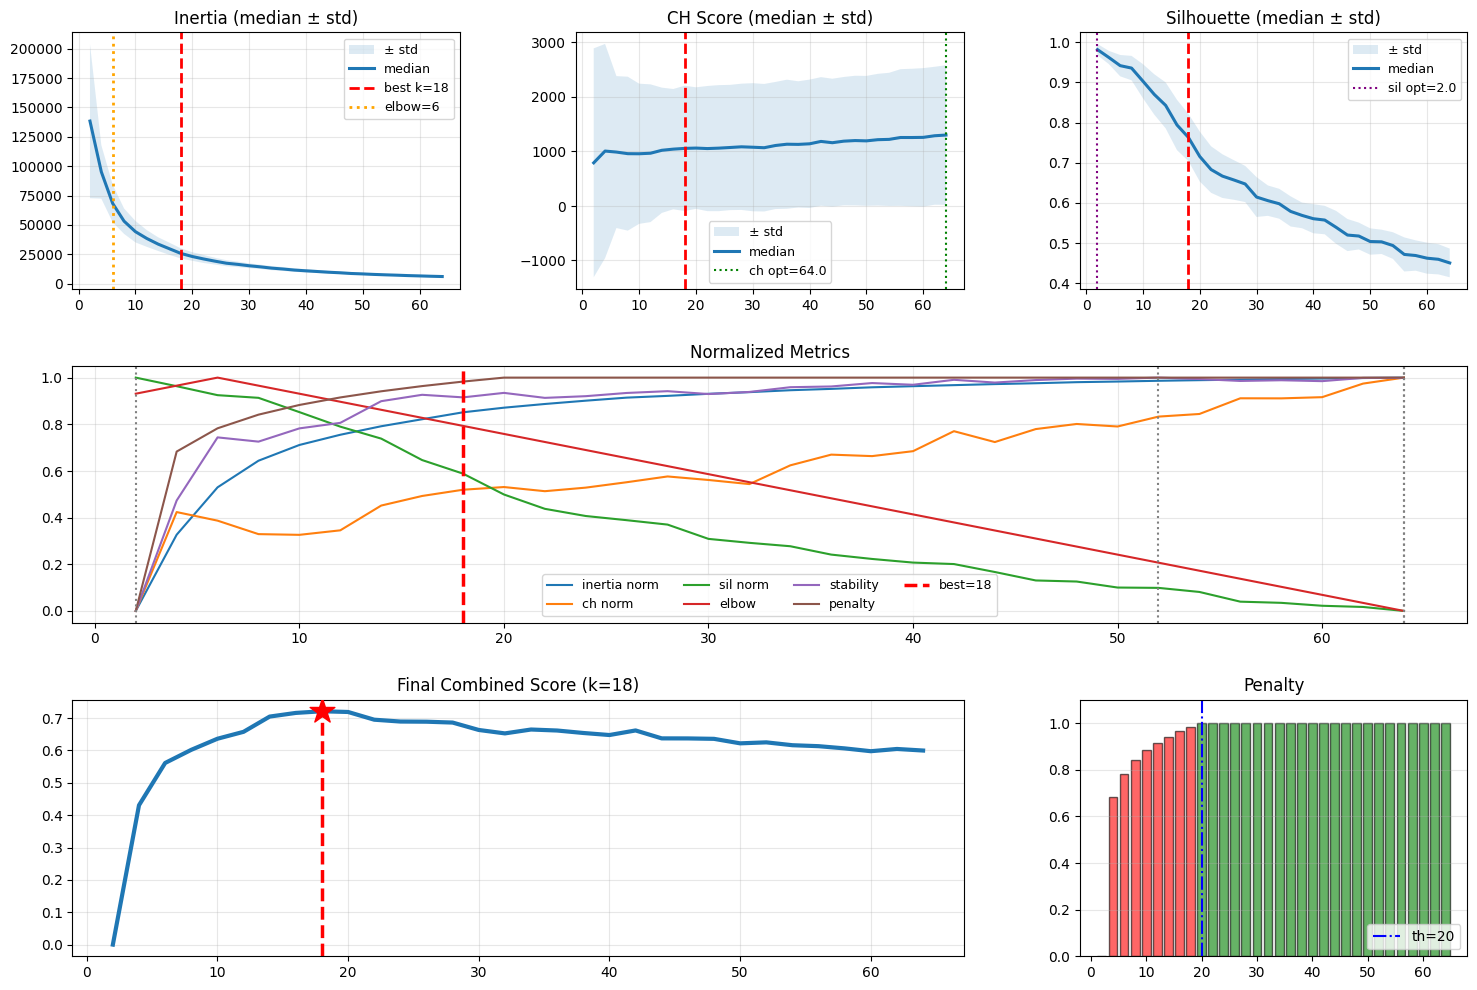


✓ Visualización corregida (mediana + std).


In [33]:
# =============================================================================
# VISUALIZACIÓN MEJORADA (MEDIANAS + STD)
# =============================================================================

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

results_sorted = results_df.sort_values('k')

# --- Plot 1: Inercia ---
ax1 = fig.add_subplot(gs[0, 0])
ax1.fill_between(k_values, inertia_median - inertia_std, inertia_median + inertia_std,
                 alpha=0.15, label='± std')
ax1.plot(k_values, inertia_median, '-', linewidth=2.2, label='median')
ax1.axvline(best_k, color='red', linestyle='--', linewidth=2, label=f'best k={best_k}')
ax1.axvline(elbow_k, color='orange', linestyle=':', linewidth=2, label=f'elbow={elbow_k}')
ax1.set_title('Inertia (median ± std)')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# --- Plot 2: CH Score ---
ax2 = fig.add_subplot(gs[0, 1])
ax2.fill_between(k_values, ch_median - ch_std, ch_median + ch_std,
                 alpha=0.15, label='± std')
ax2.plot(k_values, ch_median, '-', linewidth=2.2, label='median')
ax2.axvline(best_k, color='red', linestyle='--', linewidth=2)
ax2.axvline(k_opt_ch, color='green', linestyle=':', linewidth=1.5, label=f'ch opt={k_opt_ch}')
ax2.set_title('CH Score (median ± std)')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# --- Plot 3: Silhouette ---
ax3 = fig.add_subplot(gs[0, 2])
ax3.fill_between(k_values, sil_median - sil_std, sil_median + sil_std,
                 alpha=0.15, label='± std')
ax3.plot(k_values, sil_median, '-', linewidth=2.2, label='median')
ax3.axvline(best_k, color='red', linestyle='--', linewidth=2)
ax3.axvline(k_opt_sil, color='purple', linestyle=':', linewidth=1.5, label=f'sil opt={k_opt_sil}')
ax3.set_title('Silhouette (median ± std)')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# --- Plot 4: Métricas Normalizadas ---
ax4 = fig.add_subplot(gs[1, :])
ax4.plot(results_sorted['k'], results_sorted['inertia_norm'], label='inertia norm')
ax4.plot(results_sorted['k'], results_sorted['ch_norm'], label='ch norm')
ax4.plot(results_sorted['k'], results_sorted['sil_norm'], label='sil norm')
ax4.plot(results_sorted['k'], results_sorted['elbow_score'], label='elbow')
ax4.plot(results_sorted['k'], results_sorted['stability_score'], label='stability')
ax4.plot(results_sorted['k'], results_sorted['penalty'], label='penalty')
ax4.axvline(best_k, color='red', linestyle='--', linewidth=2.5, label=f'best={best_k}')
ax4.axvline(k_opt_inertia, color='gray', linestyle=':', linewidth=1.5)
ax4.axvline(k_opt_ch, color='gray', linestyle=':', linewidth=1.5)
ax4.axvline(k_opt_sil, color='gray', linestyle=':', linewidth=1.5)
ax4.axvline(k_opt_stability, color='gray', linestyle=':', linewidth=1.5)
ax4.set_title('Normalized Metrics')
ax4.legend(ncol=4, fontsize=9)
ax4.grid(True, alpha=0.3)

# --- Plot 5: Combined Score ---
ax5 = fig.add_subplot(gs[2, :2])
ax5.plot(results_sorted['k'], results_sorted['combined_score'], '-', linewidth=3)
ax5.axvline(best_k, color='red', linestyle='--', linewidth=2.5)
ax5.scatter([best_k], [best_score], s=350, c='red', marker='*', zorder=5)
ax5.set_title(f'Final Combined Score (k={best_k})')
ax5.grid(True, alpha=0.3)

# --- Plot 6: Penalty ---
ax6 = fig.add_subplot(gs[2, 2])
colors = ['red' if p < 1 else 'green' for p in results_sorted['penalty']]
ax6.bar(results_sorted['k'], results_sorted['penalty'],
        width=(k_values[1] - k_values[0]) * 0.8,
        color=colors, alpha=0.6, edgecolor='black')
ax6.axvline(k_min_threshold, color='blue', linestyle='-.', linewidth=1.5, label=f'th={k_min_threshold}')
ax6.set_title('Penalty')
ax6.set_ylim([0, 1.1])
ax6.legend(loc='lower right')
ax6.grid(True, alpha=0.3, axis='y')

plt.show()

print("\n✓ Visualización corregida (mediana + std).")
